In [1]:
import numpy as np
from scipy.stats import itemfreq
import networkx as nx
import pandas as pd

import matplotlib
import seaborn as sns
sns.set_palette('colorblind')
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['font.size'] = 30
matplotlib.rcParams['xtick.major.size'] = 9
matplotlib.rcParams['ytick.major.size'] = 9
matplotlib.rcParams['xtick.minor.size'] = 4
matplotlib.rcParams['ytick.minor.size'] = 4

matplotlib.rcParams['axes.linewidth'] = 2

matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['xtick.minor.width'] = 2
matplotlib.rcParams['ytick.minor.width'] = 2

matplotlib.rcParams['figure.figsize'] = [10, 8]
matplotlib.rcParams['text.usetex'] = True

import random

from toysimulations import Network

import pickle

In [2]:
def plot_probabilities(pickle_file, N, ax):
    with open(pickle_file, 'rb') as f:
        result = pickle.load(f)

    INS_DATA_COLUMNS = ['time', 'stoplist_len', 'stoplist_volume', 'rest_stoplist_volume',
                        'pickup_idx', 'dropoff_idx', 'insertion_type', 'pickup_enroute',
                        'dropoff_enroute']
    x_range = np.array(sorted(result.keys()))

    # determine how often which kind of insertion takes place
    n_arr = []
    type_arr = []
    
    for x in x_range:
        ins_df = pd.DataFrame(result[x]['insertion_data'], 
                              columns = INS_DATA_COLUMNS)

        n_arr.extend(list(ins_df['stoplist_len']))
        type_arr.extend(list(ins_df['insertion_type']))

    n_arr = np.array(n_arr)
    type_arr = np.array(type_arr)

    frac_type1 = []
    frac_type2 = []
    frac_type3 = []

    for n in set(n_arr):
        mask = (n_arr == n)
        ins_types = type_arr[mask]

        tys, counts = np.unique(ins_types, return_counts=True)
        counts = counts/counts.sum()

        for ty, cou in zip(tys, counts):
            if ty == 1:
                frac_type1.append((n, cou))
            if ty == 2:
                frac_type2.append((n, cou))
            if ty == 3:
                frac_type3.append((n, cou))
        
    # Now determine V(n) and V^{rest}(n)
    all_dfs = []

    for x in x_range:
        ins_df = pd.DataFrame(result[x]['insertion_data'], 
                              columns = INS_DATA_COLUMNS)
        ins_df.loc[:, 'x'] = x
        # cut out transients
        ins_df = ins_df[ins_df['time'] * ins_df['x'] > 20000]
        all_dfs.append(ins_df)

    master_ins_df = pd.concat(all_dfs)

    stoplist_lens = []
    vol_rests = []
    vol_totals = []

    for slen in range(1, max(master_ins_df['stoplist_len'])):
        sel = master_ins_df[master_ins_df['stoplist_len'] == slen]
        stoplist_lens.append(slen)
        vol_rests.append(sel['rest_stoplist_volume'].mean())
        vol_totals.append(sel['stoplist_volume'].mean())
    vol_totals=np.array(vol_totals)http://localhost:8891/notebooks/fig_2_insertion_probabilities.ipynb#
    vol_rests=np.array(vol_rests)

    # now plot
    ns, cs1 = zip(*frac_type1)
    ax.plot(ns, cs1, 'o', alpha=1.0, markersize=3, zorder=1)

    ns, cs2 = zip(*frac_type2)
    ax.plot(ns, cs2, 'o', alpha=1.0, markersize=3, zorder=1)

    ns, cs3 = zip(*frac_type3)
    ax.plot(ns, cs3, 'o', alpha=1.0, markersize=3, zorder=1)

    ax.set_prop_cycle(None)

    ax.plot(stoplist_lens, vol_totals/N*vol_rests/N, linewidth=3, label=r'$P_a$', alpha=0.6, zorder=3)
    ax.plot(stoplist_lens, (1-vol_rests/N)*vol_totals/N, linewidth=3, label=r'$P_b$', alpha=0.6, zorder=3)
    ax.plot(stoplist_lens, (1-vol_totals/N), linewidth=3, label=r'$P_c$', alpha=0.6, zorder=3)

    ax.set_xlabel("n")
    ax.set_ylabel('probability')

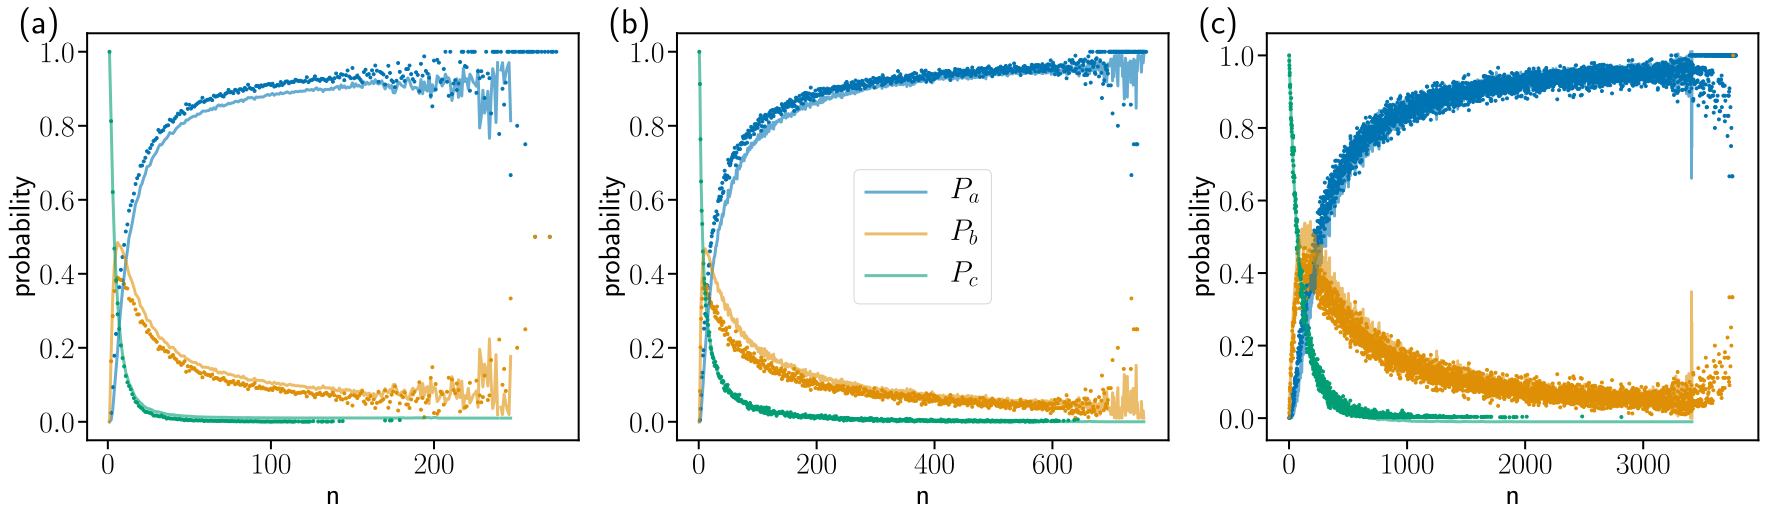

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(30, 7.5))

PICKLE_FILE = '../data/ring_100.pkl'
    #PICKLE_FILE = '../data/grid_10.pkl'
N = 101

plot_probabilities(PICKLE_FILE, N, ax1)
ax1.text(-0.14, 1, '(a)', fontsize=35, transform=ax1.transAxes)

plot_probabilities('../data/grid_10.pkl', 100, ax2)
ax2.text(-0.14, 1, '(b)', fontsize=35, transform=ax2.transAxes)
ax2.legend()

plot_probabilities('../data/star_100.pkl', 100, ax3)
ax3.text(-0.14, 1, '(c)', fontsize=35, transform=ax3.transAxes)

fig.savefig('probabilities_vs_n_measured_v_alltogether.pdf', bbox_inches='tight')